# California Housing Dataset

[![Open in Colab](https://lab.aef.me/files/assets/colab-badge.svg)](https://colab.research.google.com/github/adamelliotfields/lab/blob/main/files/california_housing.ipynb)
[![Open in Kaggle](https://lab.aef.me/files/assets/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/adamelliotfields/lab/blob/main/files/california_housing.ipynb)
[![Render nbviewer](https://lab.aef.me/files/assets/nbviewer_badge.svg)](https://nbviewer.org/github/adamelliotfields/lab/blob/main/files/california_housing.ipynb)

One of the most popular datasets for regression. The dataset contains 20640 instances and 8 features. The target variable is the median house value for a California census block from 1990.

The dataset was originally in the [StatLib](https://lib.stat.cmu.edu) dataset repository and it also made an appearance in the [Hands-On Machine Learning](https://www.amazon.com/Hands-Machine-Learning-Scikit-Learn-TensorFlow-ebook/dp/B0BHCFNY9Q/) book.

This notebook includes:
  * EDA including Folium heat map
  * Feature importances with Yellowbrick
  * SHAP summary plot
  * Robust scaling with Yeo-Johnson transformation
  * MLP pipeline

In [1]:
# %pip install -q shap

In [2]:
%matplotlib inline

In [3]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from folium import Map
from folium.plugins import HeatMap
from scipy.stats import yeojohnson
from shap import TreeExplainer, sample, summary_plot
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
    r2_score,
)
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, RobustScaler, StandardScaler
from yellowbrick.model_selection import FeatureImportances

In [4]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), "."))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# https://github.com/adamelliotfields/lab/tree/main/files/lib/
from lib import describe_dataframe, load_keras_dataset

## Data

From the Google [ML Course](https://developers.google.com/machine-learning/crash-course/california-housing-data-description):

* `longitude`: A measure of how far west a house is; a more negative value is farther west
* `latitude`: A measure of how far north a house is; a higher value is farther north
* `housing_median_age`: Median age of a house within a block; a lower number is a newer building
* `total_rooms`: Total number of rooms within a block
* `total_bedrooms`: Total number of bedrooms within a block
* `population`: Total number of people residing within a block
* `households`: Total number of households, a group of people residing within a home unit, for a block
* `median_income`: Median income for households within a block of houses (measured in tens of thousands of US Dollars)
* `median_house_value`: Median house value for households within a block (measured in US Dollars)

In [5]:
target_name = "median_house_value"
feature_names = [
    "longitude",
    "latitude",
    "housing_median_age",
    "total_rooms",
    "total_bedrooms",
    "population",
    "households",
    "median_income",
]

(X, y), _ = load_keras_dataset(
    "california_housing",
    test_split=0.0,
    as_numpy=True,
)

housing_df = pd.DataFrame(data=np.c_[X, y], columns=np.append(feature_names, target_name))
describe_dataframe(housing_df)

,count (20640),mean,std,min,median,max,mode,range,IQR,MAD,CV,skewness,kurtosis,unique,missing,dtype
longitude,20640,-119.569710,2.003532,-124.349998,-118.489998,-114.309998,-118.309998,10.040001,3.790001,1.279999,-0.016756,-0.297772,-1.330124,844,0,float32
latitude,20640,35.631859,2.135952,32.540001,34.259998,41.950001,34.060001,9.410000,3.779999,1.230000,0.059945,0.465923,-1.117777,862,0,float32
housing_median_age,20640,28.639486,12.585557,1.000000,29.000000,52.000000,52.000000,51.000000,19.000000,10.000000,0.439448,0.060326,-0.800726,52,0,float32
total_rooms,20640,2635.762939,2181.615234,2.000000,2127.000000,39320.000000,1527.000000,39318.000000,1700.250000,797.000000,0.827698,4.147042,32.622733,5926,0,float32
total_bedrooms,20640,537.898010,421.247894,1.000000,435.000000,6445.000000,280.000000,6444.000000,352.000000,163.000000,0.783137,3.452822,21.917895,1928,0,float32
population,20640,1425.476685,1132.462158,3.000000,1166.000000,35682.000000,891.000000,35679.000000,938.000000,440.000000,0.794445,4.935500,73.535017,3888,0,float32
households,20640,499.539673,382.329773,1.000000,409.000000,6082.000000,306.000000,6081.000000,325.000000,151.000000,0.765364,3.410190,22.052360,1815,0,float32
median_income,20640,3.870671,1.899822,0.499900,3.534800,15.000100,3.125000,14.500200,2.179850,1.064200,0.490825,1.646537,4.951033,12928,0,float32
median_house_value,20640,206855.812500,115395.617188,14999.000000,179700.000000,500001.000000,500001.000000,485002.000000,145125.000000,68400.000000,0.557855,0.977692,0.327501,3842,0,float32


### Geospatial data

Because we have latitude and longitude, we can plot the data using a scatter plot colored by house value, and a density plot shaded by how populated the area is. For an interactive map, we can use Folium with a heat map overlay.

Along the coast the homes are more expensive; and SoCal and Bay Area are more densely populated.

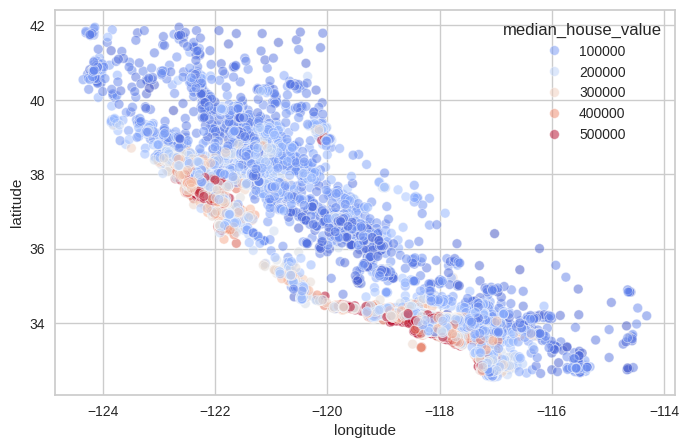

In [6]:
# scatter plot
plt.figure(figsize=(8, 5))
sns.scatterplot(
    housing_df,
    x="longitude",
    y="latitude",
    hue="median_house_value",
    palette="coolwarm",
    alpha=0.5,
);

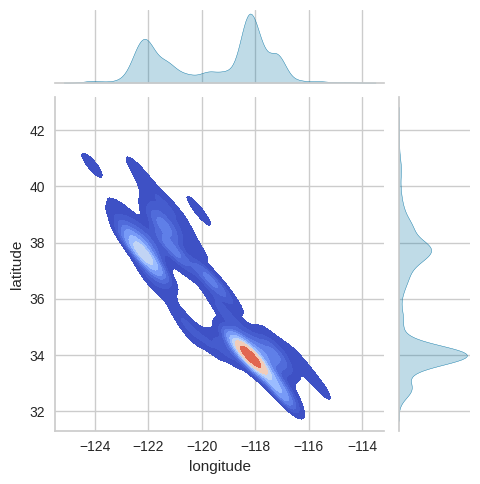

In [7]:
# density plot
sns.jointplot(
    housing_df,
    x="longitude",
    y="latitude",
    kind="kde",  # also hex
    cmap="coolwarm",
    height=5,
    ratio=4,
    # fill the kde
    fill=True,
);

In [ ]:
# folium heat map
center = [
    housing_df.latitude.mean(),
    housing_df.longitude.mean(),
]

m = Map(location=center, zoom_start=7)
heat_data = [[row.latitude, row.longitude] for _, row in housing_df.iterrows()]
HeatMap(heat_data).add_to(m)

m  # render

### Scale and transform

Because the features have different scales, we will need to scale them before training the model. We can use a `StandardScaler` from scikit-learn. After scaling, we can use Yeo-Johnson transformation to make the data more Gaussian-like.

In [9]:
standard_scaler = StandardScaler()
robust_scaler = RobustScaler()

X_standard = standard_scaler.fit_transform(X)
X_robust = robust_scaler.fit_transform(X)

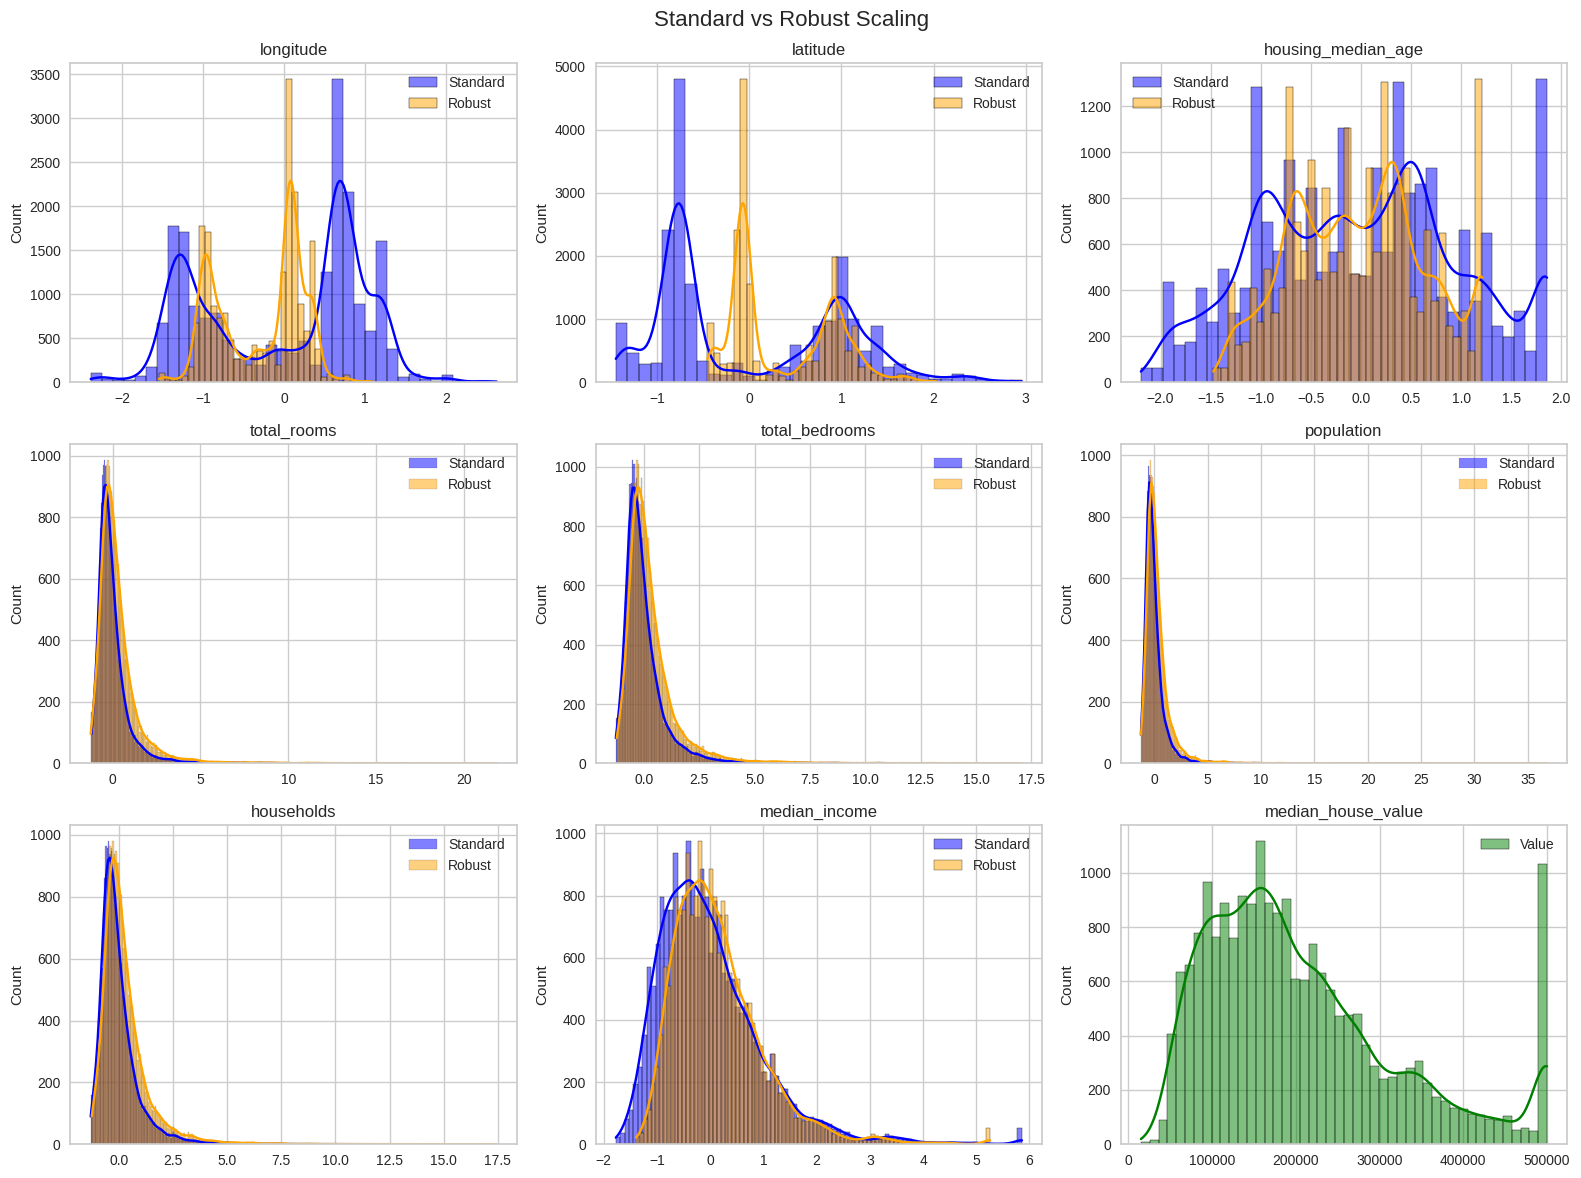

In [10]:
# plot standard vs robust scaling
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16, 12))
fig.suptitle("Standard vs Robust Scaling", fontsize=16)

for i, col in enumerate(feature_names):
    sns.histplot(
        X_standard[:, i],
        kde=True,
        color="blue",
        ax=axes[i // 3, i % 3],
        label="Standard",
    )
    sns.histplot(
        X_robust[:, i],
        kde=True,
        color="orange",
        ax=axes[i // 3, i % 3],
        label="Robust",
    )
    axes[i // 3, i % 3].set_title(col)
    axes[i // 3, i % 3].legend()

# plot house value in green in 9th ax
sns.histplot(
    y,
    kde=True,
    color="green",
    ax=axes[2, 2],
    label="Value",
)
axes[2, 2].set_title(target_name)
axes[2, 2].legend()
plt.tight_layout();

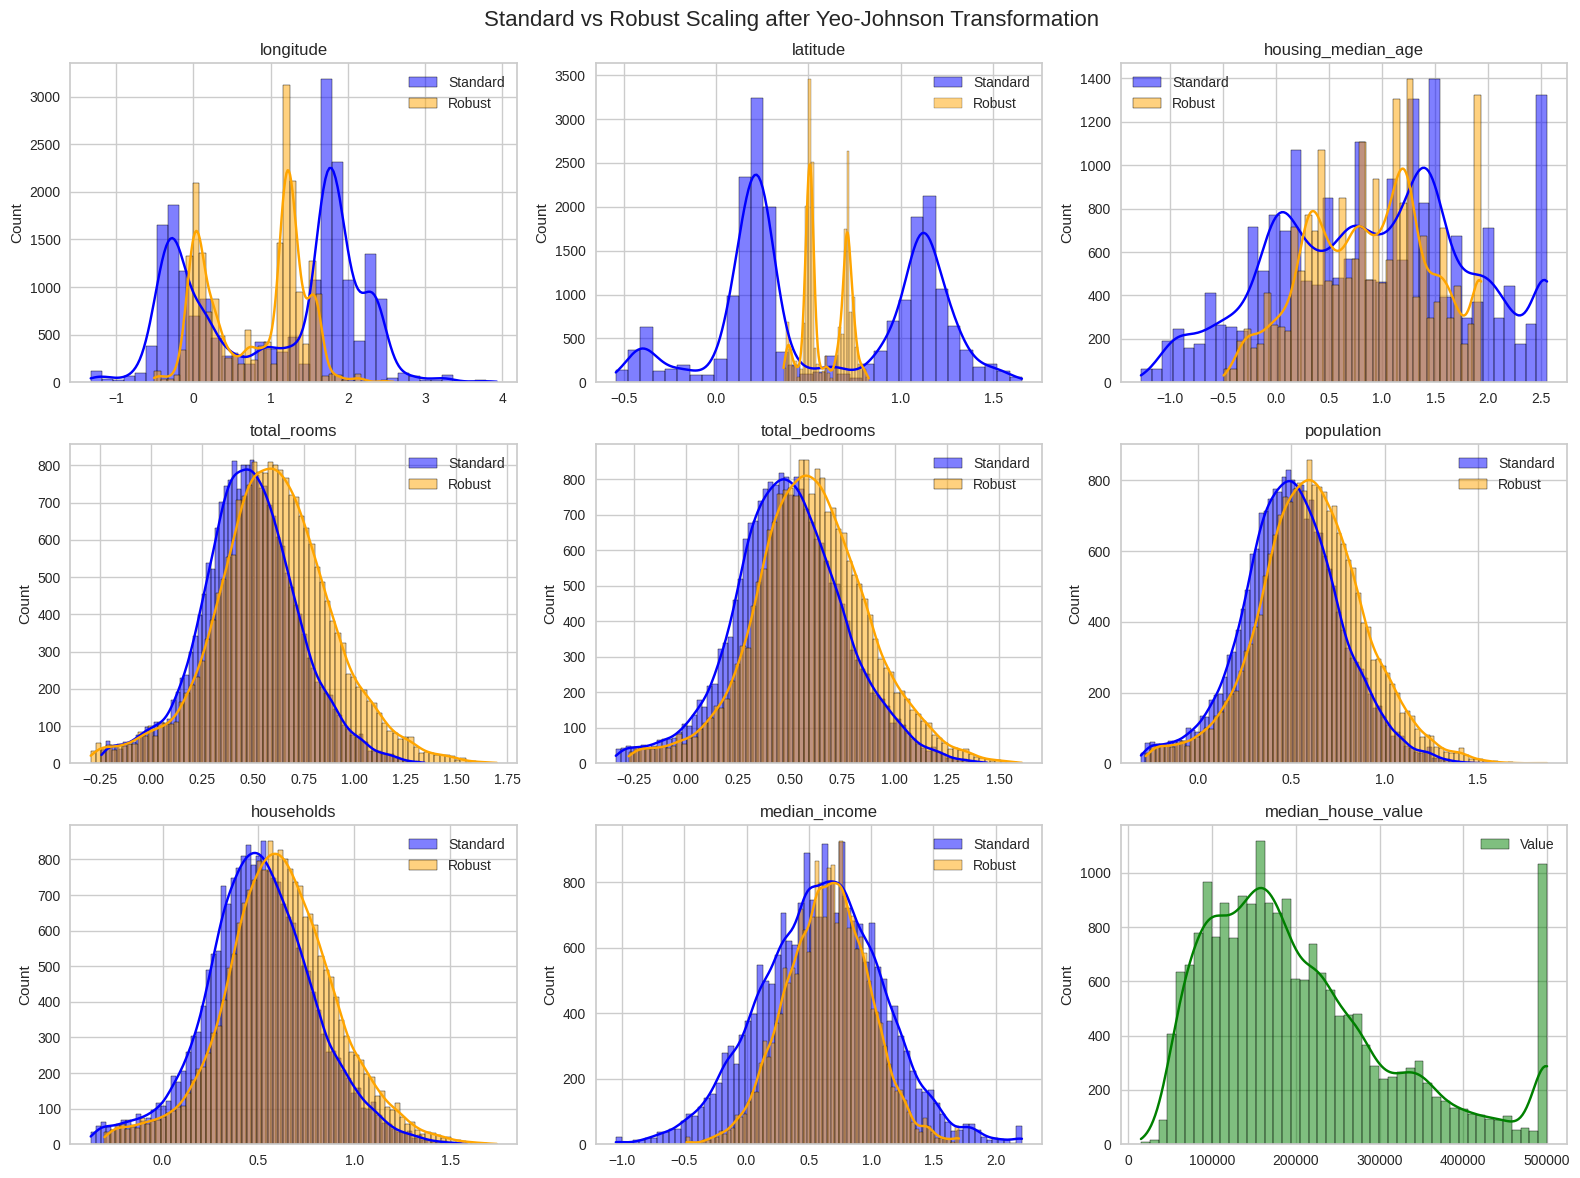

In [11]:
X_standard_trans = X_standard.copy()
X_standard_trans = np.apply_along_axis(
    lambda x: yeojohnson(x + 1)[0],
    arr=X_standard_trans,
    axis=0,
)

X_robust_trans = X_robust.copy()
X_robust_trans = np.apply_along_axis(
    lambda x: yeojohnson(x + 1)[0],
    arr=X_robust_trans,
    axis=0,
)

# replot
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16, 12))
fig.suptitle("Standard vs Robust Scaling after Yeo-Johnson Transformation", fontsize=16)

for i, col in enumerate(feature_names):
    sns.histplot(
        X_standard_trans[:, i],
        kde=True,
        color="blue",
        ax=axes[i // 3, i % 3],
        label="Standard",
    )
    sns.histplot(
        X_robust_trans[:, i],
        kde=True,
        color="orange",
        ax=axes[i // 3, i % 3],
        label="Robust",
    )
    axes[i // 3, i % 3].set_title(col)
    axes[i // 3, i % 3].legend()

# plot house value in green in 9th ax
sns.histplot(
    y,
    kde=True,
    color="green",
    ax=axes[2, 2],
    label="Value",
)
axes[2, 2].set_title(target_name)
axes[2, 2].legend()
plt.tight_layout();

In [12]:
# random forest regressor for feature importances
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train_robust, X_test_robust, y_train_robust, y_test_robust = train_test_split(
#     X_robust, y, test_size=0.2, random_state=42
# )

In [ ]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

In [14]:
y_pred_rf = rf.predict(X_test)
print(f"Test R^2: {r2_score(y_test, y_pred_rf)}")
print(f"Test MSE: {mean_squared_error(y_test, y_pred_rf)}")
print(f"Test MAE: {mean_absolute_error(y_test, y_pred_rf)}")
print(f"Test MAPE: {mean_absolute_percentage_error(y_test, y_pred_rf)}")

Test R^2: 0.8274742778986619
Test MSE: 2310434486.3439164
Test MAE: 31088.869980620155
Test MAPE: 0.16927586409485904


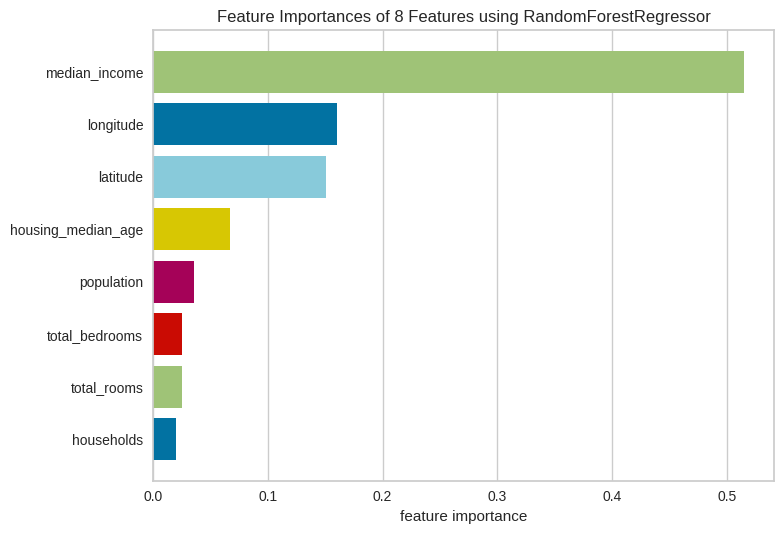

In [15]:
viz = FeatureImportances(rf, labels=feature_names, relative=False)
viz.fit(X_train, y_train)
viz.show();

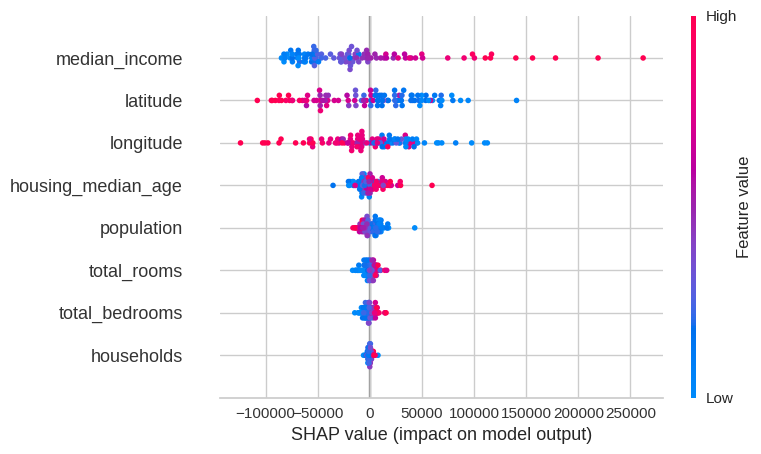

In [16]:
explainer = TreeExplainer(rf)
X_train_sample = sample(X_train, 100)
shap_values = explainer.shap_values(X_train_sample)
summary_plot(shap_values, X_train_sample, feature_names=feature_names)

In [ ]:
def yeojohnson_transform(x):
    return np.apply_along_axis(lambda x: yeojohnson(x + 1)[0], arr=x, axis=0)


# scale before transform
pipe = make_pipeline(
    RobustScaler(),
    FunctionTransformer(
        func=yeojohnson_transform,
        validate=False,
    ),
    MLPRegressor(
        hidden_layer_sizes=(64, 128),
        learning_rate="adaptive",
        learning_rate_init=0.003,
        activation="relu",
        solver="adam",
        alpha=0.0002,
        max_iter=200,
        shuffle=False,
        batch_size=200,
        random_state=42,
        # early stopping
        early_stopping=True,
        n_iter_no_change=10,
        tol=0.001,
    ),
)

pipe.fit(X_train, y_train)

In [18]:
y_pred_mlp = pipe.predict(X_test)
print(f"Test R^2: {r2_score(y_test, y_pred_mlp)}")
print(f"Test MSE: {mean_squared_error(y_test, y_pred_mlp)}")
print(f"Test MAE: {mean_absolute_error(y_test, y_pred_mlp)}")
print(f"Test MAPE: {mean_absolute_percentage_error(y_test, y_pred_mlp)}")

Test R^2: 0.6791527103080159
Test MSE: 4296731136.0
Test MAE: 47853.7734375
Test MAPE: 0.2839239537715912


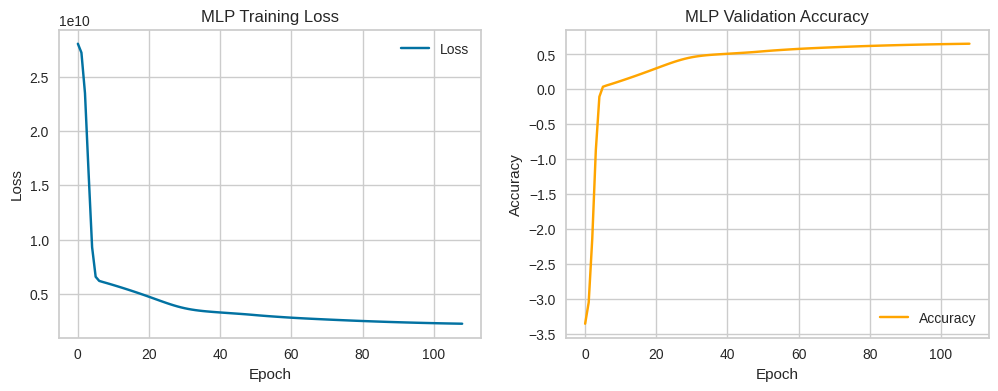

In [19]:
# plt side-by-side
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
axes[0].plot(pipe.named_steps["mlpregressor"].loss_curve_)
axes[0].set_title("MLP Training Loss")
axes[0].legend(["Loss"])
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")

axes[1].plot(pipe.named_steps["mlpregressor"].validation_scores_, color="orange")
axes[1].set_title("MLP Validation Accuracy")
axes[1].legend(["Accuracy"])
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy");